In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report)
from sklearn.feature_selection import VarianceThreshold

In [6]:
df = pd.read_csv("credit.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
y = df["Class"]          # Target variable (Default / Non-default)
X = df.drop("Class", axis=1)

In [10]:
print(y.value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [11]:
# train_test_split (stratifiedKFold)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
) #stratify=y ensures both sets keep the same class ratio

In [12]:
# feature selection high dimentional data
selector = VarianceThreshold(threshold=0.01)

X_train_sel = selector.fit_transform(X_train)
X_test_sel = selector.transform(X_test)
#Removes features with almost no variation
#Reduces noise, dimensionality, and overfitting
#Improves generalisation

In [13]:
# train decision tree with class weighing
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

dt_model.fit(X_train_sel, y_train)  
#class_weight="balanced" → handles class imbalance
#max_depth → prevents deep, overfitted tree
#min_samples_leaf → avoids very small, noisy leaf nodes

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [15]:
# make prediction
y_pred = dt_model.predict(X_test_sel)
y_prob = dt_model.predict_proba(X_test_sel)[:, 1]
#y_pred → predicted class labels
#y_prob → predicted probabilities (needed for ROC-AUC)

In [18]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#Confusion matrix shows TP, FP, FN, TN
#Focus on recall and F1-score for minority class

Confusion Matrix:
[[55131  1733]
 [   12    86]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.88      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [19]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
#F1 balances precision and recall
#Best metric for imbalanced classification

F1 Score: 0.08972352634324465


In [20]:
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)
#Measures class separability
#Threshold-independent metric

ROC-AUC Score: 0.9165507139124642


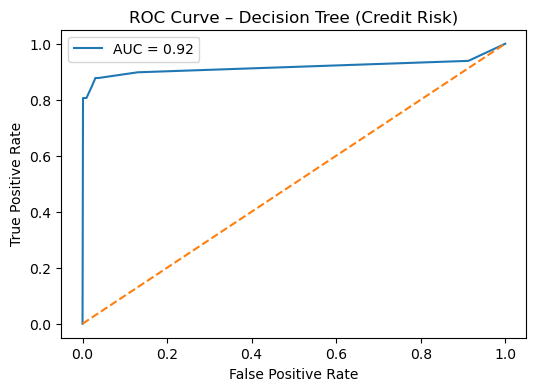

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree (Credit Risk)")
plt.legend()
plt.show()

#Visualises trade-off between sensitivity and specificity
#Curve closer to top-left → better model